In [3]:
pip install nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.6 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from tensorflow.keras.layers import *

D1122 06:20:40.686385056      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1122 06:20:40.686433884      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1122 06:20:40.686437623      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1122 06:20:40.686440327      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1122 06:20:40.686442879      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1122 06:20:40.686445703      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1122 06:20:40.686448437      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1122 06:20:40.

In [5]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}
IMG_SIZE=128
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [6]:
def show_imgs(paths, i):
    sub_path = sorted(os.listdir(TRAIN_DATASET_PATH + paths[i]))
    
    image_flair = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' +sub_path[0]).get_fdata()
    mask = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[1]).get_fdata()
    image_t1 = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[2]).get_fdata()
    image_t1ce = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[3]).get_fdata()
    image_t2 = nib.load(TRAIN_DATASET_PATH + paths[i]+ '/' + sub_path[4]).get_fdata()
    
    print(f"Height of the image: {image_flair.shape[0]}")
    print(f"width of the image: {image_flair.shape[1]}")
    print(f"number of slices of volume of the image: {image_flair.shape[-1]}")
    print()
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
    slice_w = 25
    ax1.imshow(image_flair[:,:,image_flair.shape[0]//2-slice_w], cmap = 'gray')
    ax1.set_title('Image flair')
    ax1.axis(False)
    ax2.imshow(image_t1[:,:,image_t1.shape[0]//2-slice_w], cmap = 'gray')
    ax2.set_title('Image t1')
    ax2.axis(False)
    ax3.imshow(image_t1ce[:,:,image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
    ax3.set_title('Image t1ce')
    ax3.axis(False)
    ax4.imshow(image_t2[:,:,image_t2.shape[0]//2-slice_w], cmap = 'gray')
    ax4.set_title('Image t2')
    ax4.axis(False)
    ax5.imshow(image_flair[:,:,image_flair.shape[0]//2-slice_w], cmap="OrRd", alpha=1.0)
    ax5.imshow(mask[:,:,mask.shape[0]//2-slice_w], alpha=0.2, cmap="OrRd")
    ax5.set_title('Mask')
    ax5.axis(False)
    print()
#     plt.imshow(mask, cmap='reds')
    plt.show()
    

Height of the image: 240
width of the image: 240
number of slices of volume of the image: 155




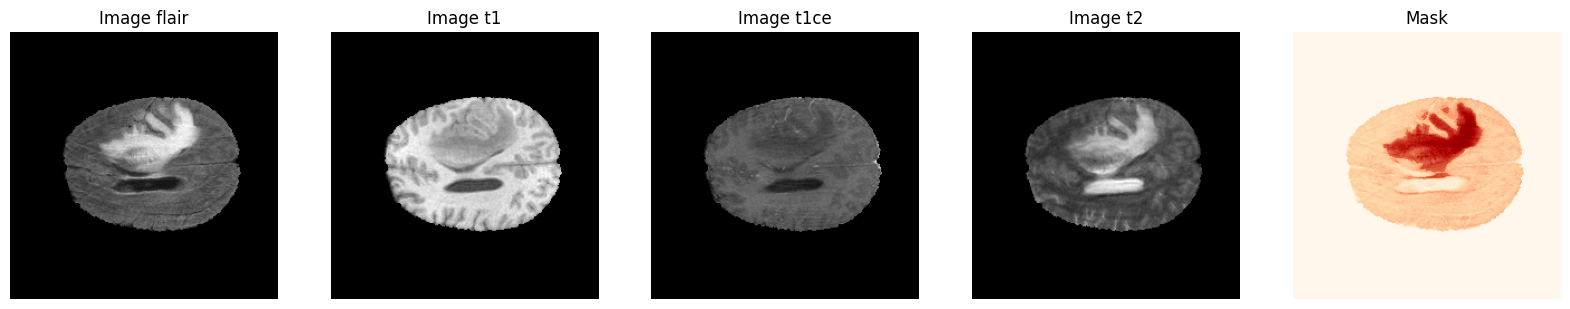

Height of the image: 240
width of the image: 240
number of slices of volume of the image: 155




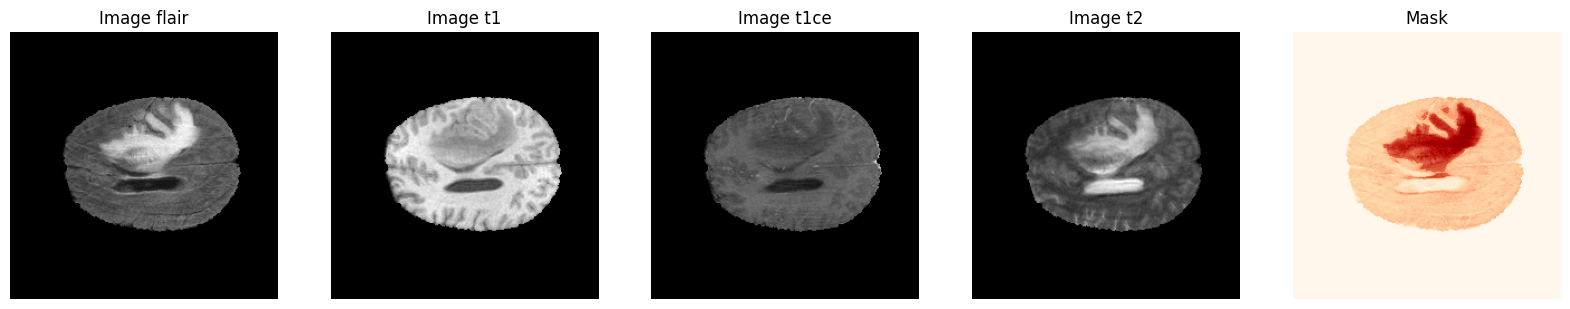

In [7]:
path = sorted(os.listdir(r"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"))
show_imgs(path, 0) # with Tumor
path = sorted(os.listdir(r"/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"))
show_imgs(path, 0) # with Tumor

In [8]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [9]:
tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet').summary

9406464/9406464 [==============================] - 0s 0us/step


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7a53e899dfa0>>

In [10]:
def generate_data(list_ids, batch_size, img_size):
    while True:
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        indexes = np.arange(len(list_ids))
    #     indexes = indexes[index*batch_size:(index+1)*batch_size]
        np.random.shuffle(indexes)
        Batch_ids = [list_ids[k] for k in indexes[:batch_size]]

        # Initialization
        X = np.zeros((batch_size*VOLUME_SLICES, img_size[0], img_size[1], img_size[2]))
        y = np.zeros((batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((batch_size*VOLUME_SLICES, img_size[0], img_size[1], 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))   
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, len(SEGMENT_CLASSES))
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        yield X/np.max(X), Y
        

def data_generator_wrapper(list_ids, batch_size=1, img_size=(IMG_SIZE, IMG_SIZE, 2)):
    if len(list_ids)==0 or batch_size<=0: return None
    return generate_data(list_ids, batch_size, img_size)

In [11]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [12]:
def DeepLabV3Plus_UNet(input_shape, num_classes):
    # U-Net architecture
    def UNet(input_tensor):
        # Downsample path
        conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
        
        # Bridge
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

        # Upsample path
        up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
        concat6 = Concatenate()([up6, conv4])
        conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat6)
        
        up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
        concat7 = Concatenate()([up7, conv3])
        conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat7)
        
        up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
        concat8 = Concatenate()([up8, conv2])
        conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat8)
        
        up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
        concat9 = Concatenate()([up9, conv1])
        conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat9)
        
        return conv9
    
    # DeepLabv3+ architecture
    def DeepLabV3Plus(input_tensor):
        # DeepLabv3+ implementation (without ASPP module)
        # Modify this part to include ASPP module
        x = Conv2D(filters=3,kernel_size=3,  padding='same', activation='relu')(input_tensor)
        # Backbone (e.g., ResNet, MobileNetV2)
        backbone = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')
        backbone_output = backbone(x)
        
        # Upsampling
        upsample1 = UpSampling2D((4, 4))(backbone_output)
        
        # U-Net path
        unet_output = UNet(upsample1)
        
        # upsampling and Convolutional layers
        upsample2 = UpSampling2D((8, 8))(unet_output)
        x = Conv2D(64, (3, 3), padding='same', activation='relu')(upsample2)
        x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        
        # Final prediction
        output = Conv2D(num_classes, (1, 1), activation='softmax')(x)
        
        return output
    
    # Input tensor
    input_tensor = Input(shape=input_shape)
    
    
    # DeepLabv3+ with U-Net
    deep_lab_unet_output = DeepLabV3Plus(input_tensor)
    
    # Create the model
    return tf.keras.Model(inputs=input_tensor, outputs=deep_lab_unet_output)

In [13]:
input_shape = (IMG_SIZE,IMG_SIZE, 2)
num_classes = len(SEGMENT_CLASSES)
model_2 = DeepLabV3Plus_UNet(input_shape, num_classes)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  57          ['input_2[0][0]']                
                                                                                                  
 mobilenetv2_1.00_128 (Function  (None, 4, 4, 1280)  2257984     ['conv2d[0][0]']                 
 al)                                                                                              
                                                                                              

In [14]:
from tensorflow.keras.utils import plot_model

# Plot the model structure
tf.keras.utils.plot_model(model_2, to_file='deeplabv3plus_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
model_2.compile(loss="categorical_crossentropy", optimizer='adam', 
             metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=len(SEGMENT_CLASSES)), 
                        dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                        dice_coef_edema ,dice_coef_enhancing])

In [16]:
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
checkpoints_cb = ModelCheckpoint("model_weights_vir.h5", save_best_only=True, verbose=1)
reducee_lr_cb = ReduceLROnPlateau(patience=3, verbose=1)



callbackss = [checkpoints_cb, reducee_lr_cb, early_stopping_cb]

In [17]:
batch_size=1
history = model_2.fit(data_generator_wrapper(train_ids, batch_size=batch_size), 
                    epochs=3,
                    steps_per_epoch=max(1, len(train_ids)//batch_size), 
                    validation_data=data_generator_wrapper(val_ids, batch_size=batch_size), 
                    validation_steps=max(1, len(val_ids)//batch_size), 
                    initial_epoch=0, 
                    callbacks = callbackss)

Epoch 1/3
249/249 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9811 - mean_io_u: 0.5435 - dice_coef: 0.3145 - precision: 0.9859 - sensitivity: 0.9764 - specificity: 0.9960 - dice_coef_necrotic: 0.1722 - dice_coef_edema: 0.2335 - dice_coef_enhancing: 0.1490
Epoch 1: val_loss improved from inf to 0.52450, saving model to model_weights_vir.h5
249/249 [==============================] - 927s 4s/step - loss: 0.0667 - accuracy: 0.9811 - mean_io_u: 0.5435 - dice_coef: 0.3145 - precision: 0.9859 - sensitivity: 0.9764 - specificity: 0.9960 - dice_coef_necrotic: 0.1722 - dice_coef_edema: 0.2335 - dice_coef_enhancing: 0.1490 - val_loss: 0.5245 - val_accuracy: 0.9857 - val_mean_io_u: 0.9570 - val_dice_coef: 0.2546 - val_precision: 0.9857 - val_sensitivity: 0.9857 - val_specificity: 0.9952 - val_dice_coef_necrotic: 0.0041 - val_dice_coef_edema: 0.0179 - val_dice_coef_enhancing: 0.0039 - lr: 0.0010
Epoch 2/3
249/249 [==============================] - ETA: 0s - loss: 0.0452 

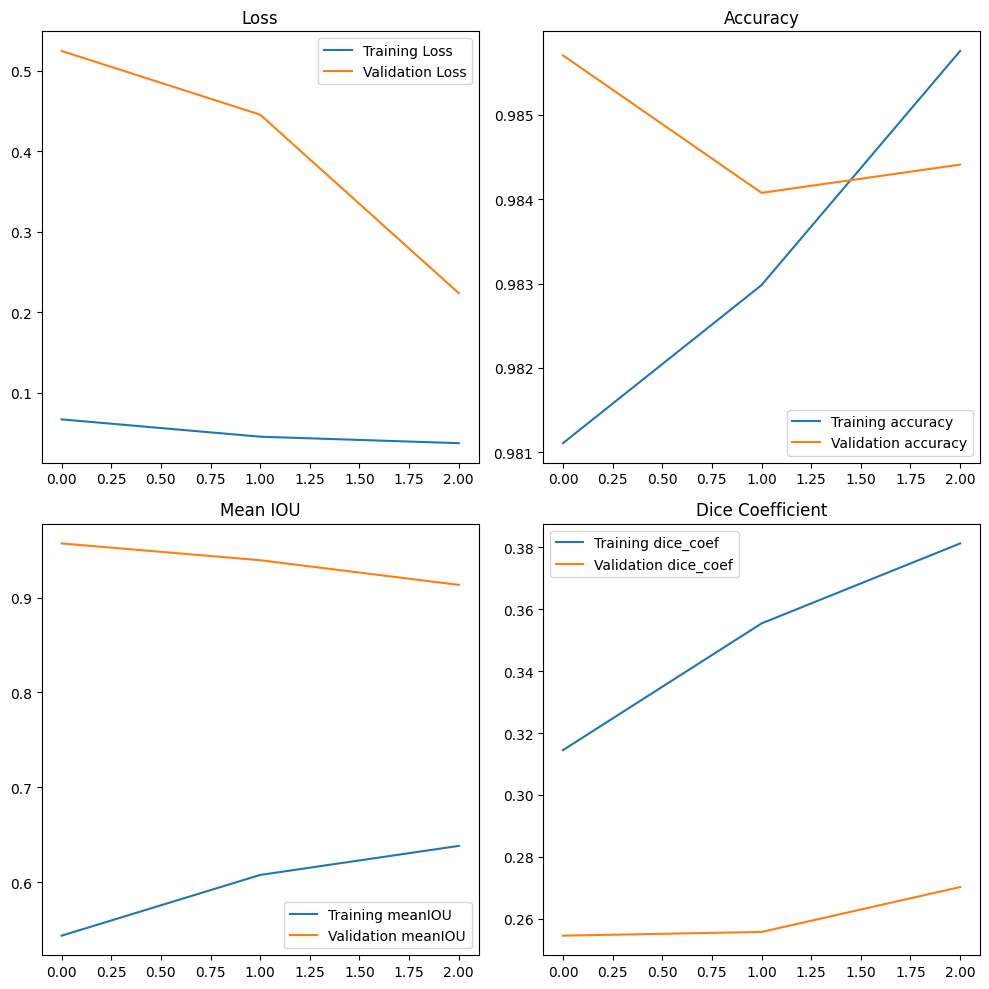

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(history.history['loss'], label="Training Loss")
ax[0, 0].plot(history.history['val_loss'], label='Validation Loss')
ax[0, 0].set_title('Loss')
ax[0, 0].legend()

ax[0, 1].plot(history.history['accuracy'], label="Training accuracy")
ax[0, 1].plot(history.history['val_accuracy'], label='Validation accuracy')
ax[0, 1].set_title("Accuracy")
ax[0, 1].legend()

ax[1, 0].plot(history.history['mean_io_u'], label="Training meanIOU")
ax[1, 0].plot(history.history['val_mean_io_u'], label='Validation meanIOU')
ax[1, 0].set_title("Mean IOU")
ax[1, 0].legend()

ax[1, 1].plot(history.history['dice_coef'], label="Training dice_coef")
ax[1, 1].plot(history.history['val_dice_coef'], label='Validation dice_coef')
ax[1, 1].set_title("Dice Coefficient")
ax[1, 1].legend()

plt.tight_layout()

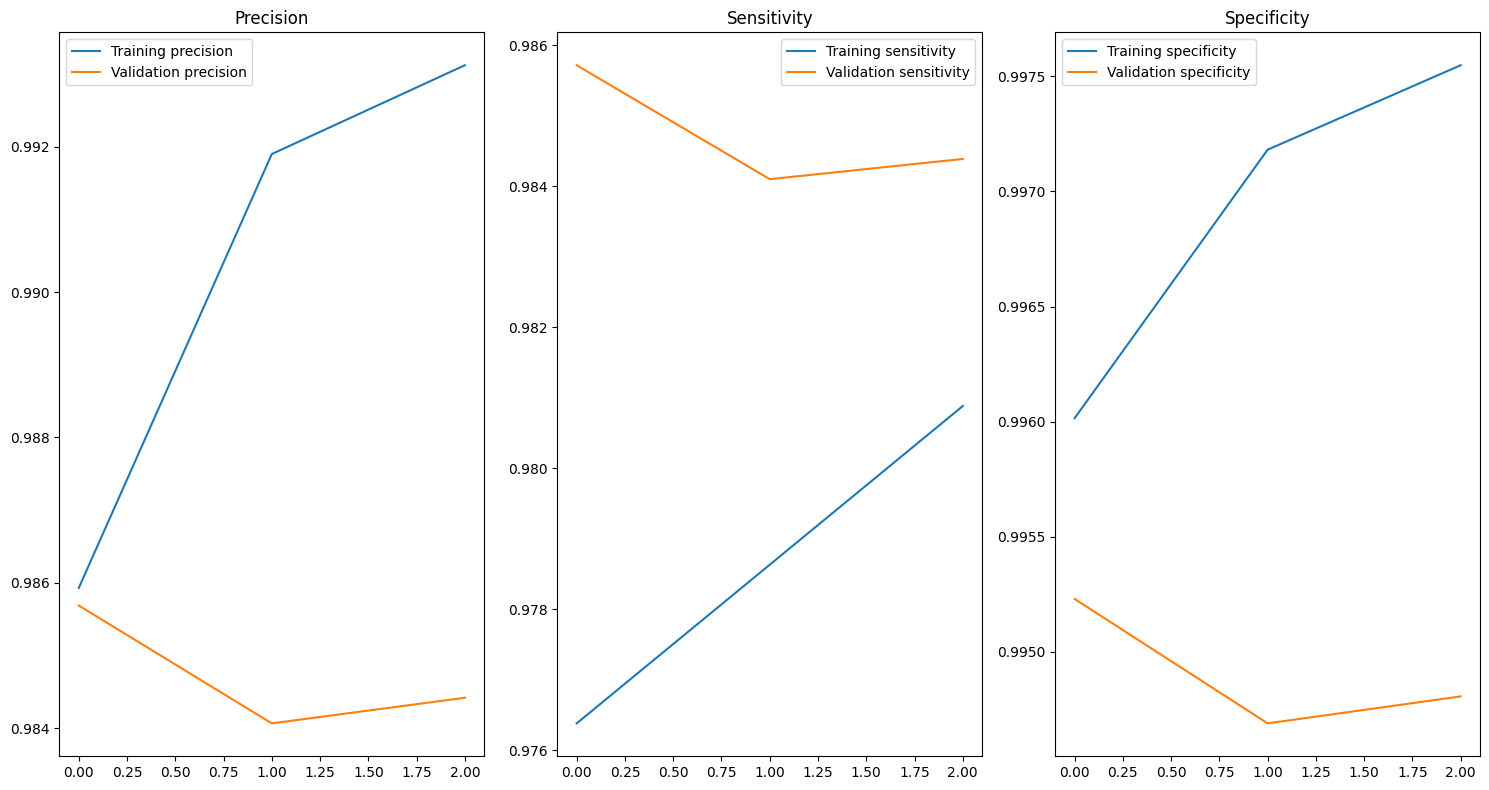

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].plot(history.history['precision'], label="Training precision")
ax[0].plot(history.history['val_precision'], label='Validation precision')
ax[0].set_title('Precision')
ax[0].legend()

ax[1].plot(history.history['sensitivity'], label="Training sensitivity")
ax[1].plot(history.history['val_sensitivity'], label='Validation sensitivity')
ax[1].set_title("Sensitivity")
ax[1].legend()

ax[2].plot(history.history['specificity'], label="Training specificity")
ax[2].plot(history.history['val_specificity'], label='Validation specificity')
ax[2].set_title("Specificity")
ax[2].legend()

plt.tight_layout()

In [20]:
def predict_tumors(case, start_slice = 60):
    path = TRAIN_DATASET_PATH + "/" + case     
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    flair = nib.load(path + "/" + case + "_flair.nii").get_fdata()
    mask = nib.load(path + "/" + case + "_seg.nii").get_fdata()
    ce = nib.load(path + "/" + case + "_t1ce.nii").get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    pred = model_2.predict(X/np.max(X), verbose=1)

    core = pred[:,:,:,1]
    edema= pred[:,:,:,2]
    enhancing = pred[:,:,:,3]

    f, ax = plt.subplots(2, 3) 

    for i in range(2): # for each image, add brain background
        for j in range(3):
            ax[i, j].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    ax[0, 0].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    ax[0, 0].title.set_text('Original image flair')
    
    mask=cv2.resize(mask[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    ax[0, 1].imshow(mask, cmap="Reds", interpolation='none', alpha=0.3)
    ax[0, 1].title.set_text('Ground truth')
    
    ax[0, 2].imshow(pred[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    ax[0, 2].title.set_text('all classes')
    
    ax[1, 0].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[1, 0].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    
    ax[1, 1].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[1, 1].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    
    ax[1, 2].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    ax[1, 2].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    
    plt.tight_layout()
    plt.show()
    print("\n")

4/4 [==============================] - 1s 107ms/step


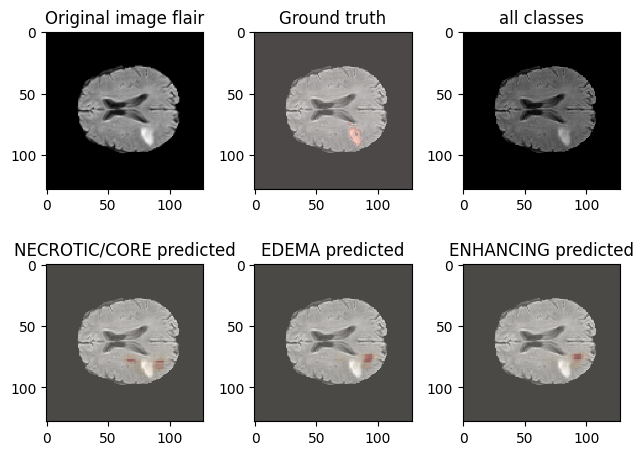



4/4 [==============================] - 0s 111ms/step


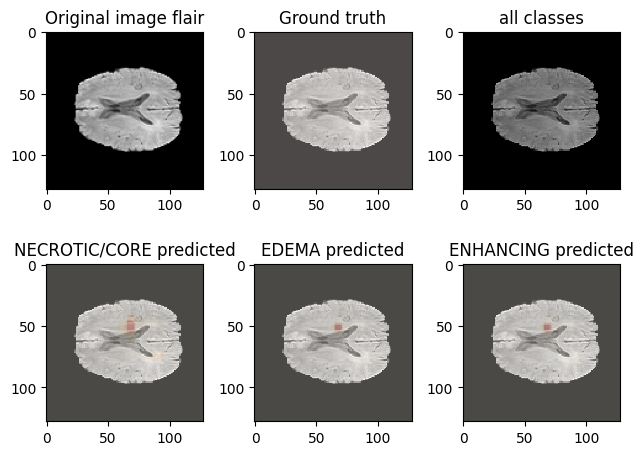



4/4 [==============================] - 0s 109ms/step


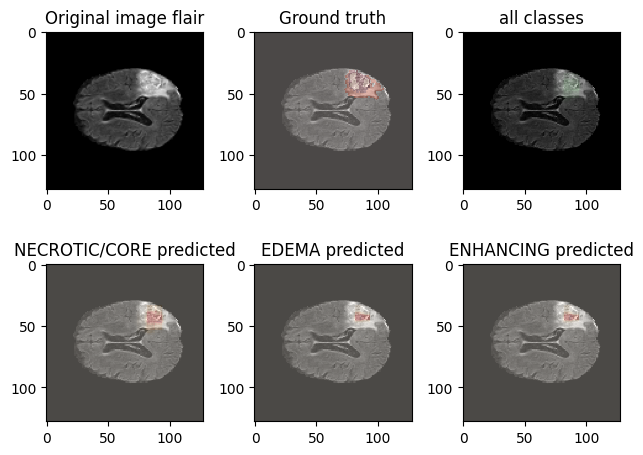



4/4 [==============================] - 1s 113ms/step


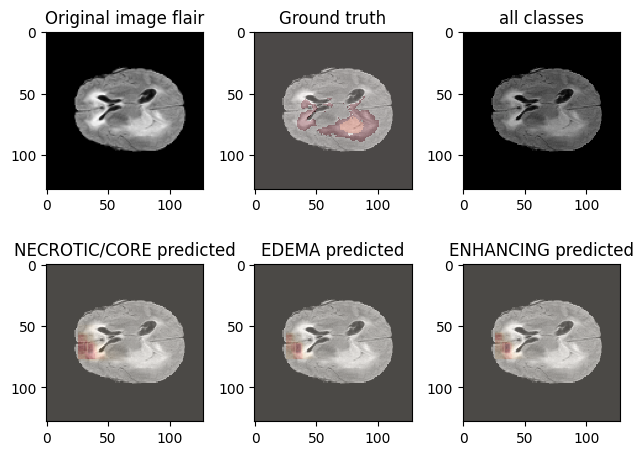



4/4 [==============================] - 0s 107ms/step


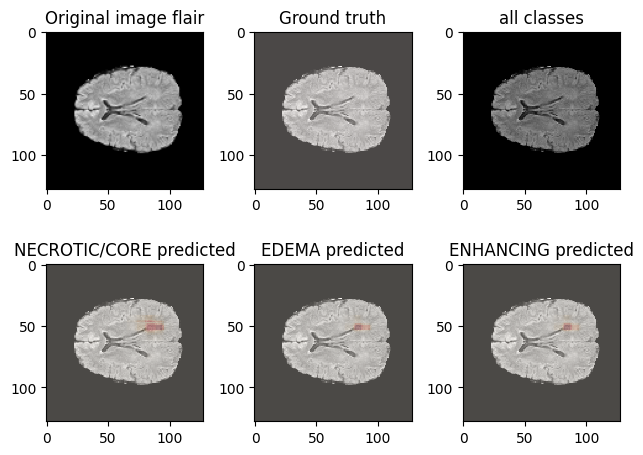

In [21]:
for ids in np.random.choice(train_ids, size=5, replace=False):
    predict_tumors(ids)

In [22]:
import pandas as pd

# Get the accuracy, loss, sensitivity, specificity, and precision from the history
accuracy = history.history['accuracy']
loss = history.history['loss']
sensitivity = history.history['sensitivity']
specificity = history.history['specificity']
precision = history.history['precision']

# Create a DataFrame
df = pd.DataFrame({'Epoch': range(1, len(accuracy) + 1), 'Accuracy': accuracy, 'Loss': loss, 'Sensitivity': sensitivity, 'Specificity': specificity, 'Precision': precision})

# Print the DataFrame
print(df)

   Epoch  Accuracy      Loss  Sensitivity  Specificity  Precision
0      1  0.981108  0.066693     0.976379     0.996015   0.985931
1      2  0.982981  0.045183     0.978630     0.997181   0.991897
2      3  0.985756  0.037138     0.980880     0.997548   0.993118


In [23]:
import os
import nibabel as nib
import numpy as np
from tabulate import tabulate

# Directory paths where the NIfTI files are located
nifti_dir_train = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001"
nifti_dir_val = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/"

# Initialize a list to store the modalities and standard deviations
modalities_list = []

# Iterate over the files in the training data directory
for file_name_train in os.listdir(nifti_dir_train):
    # Check if the file is a NIfTI file
    if file_name_train.endswith(".nii") or file_name_train.endswith(".nii.gz"):
        # Get the file path
        file_path_train = os.path.join(nifti_dir_train, file_name_train)
        # Load the NIfTI file
        nifti_img_train = nib.load(file_path_train)
        # Get the image data array
        image_data_train = nifti_img_train.get_fdata()
        # Calculate the mean and standard deviation of the modalities
        modalities_mean_train = np.mean(image_data_train, axis=(0, 1, 2))
        modalities_std_train = np.std(image_data_train, axis=(0, 1, 2))
        # Append the modalities and standard deviations to the list
        modalities_list.append([file_name_train, modalities_mean_train, modalities_std_train])

# Iterate over the files in the validation data directory
for file_name_val in os.listdir(nifti_dir_val):
    # Check if the file is a NIfTI file
    if file_name_val.endswith(".nii") or file_name_val.endswith(".nii.gz"):
        # Get the file path
        file_path_val = os.path.join(nifti_dir_val, file_name_val)
        # Load the NIfTI file
        nifti_img_val = nib.load(file_path_val)
        # Get the image data array
        image_data_val = nifti_img_val.get_fdata()
        # Calculate the mean and standard deviation of the modalities
        modalities_mean_val = np.mean(image_data_val, axis=(0, 1, 2))
        modalities_std_val = np.std(image_data_val, axis=(0, 1, 2))
        # Append the modalities and standard deviations to the list
        modalities_list.append([file_name_val, modalities_mean_val, modalities_std_val])

# Define the table headers
headers = ["NIfTI File", "Mean", "Standard Deviation"]

# Print the table
print(tabulate(modalities_list, headers, tablefmt="grid"))

+----------------------------------+------------+----------------------+
| NIfTI File                       |       Mean |   Standard Deviation |
+==================================+============+======================+
| BraTS20_Training_001_t2.nii      | 17.2514    |            44.9792   |
+----------------------------------+------------+----------------------+
| BraTS20_Training_001_t1ce.nii    | 62.7716    |           155.079    |
+----------------------------------+------------+----------------------+
| BraTS20_Training_001_t1.nii      | 53.2871    |           130.785    |
+----------------------------------+------------+----------------------+
| BraTS20_Training_001_seg.nii     |  0.0519712 |             0.352661 |
+----------------------------------+------------+----------------------+
| BraTS20_Training_001_flair.nii   | 26.0219    |            66.7654   |
+----------------------------------+------------+----------------------+
| BraTS20_Validation_001_t2.nii    | 30.1645    |  

In [24]:
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk

# Provide the path to your input image
image_path = "/path/to/your/image.nii"

# Load the image
image = nib.load(image_path)
image_data = image.get_fdata()

# Display slices of the image
num_slices = image_data.shape[-1]  # Number of slices in the image
mid_slice = num_slices // 2  # Select the middle slice or adjust as needed

# Display the selected slice
plt.imshow(image_data[..., mid_slice], cmap='gray')
plt.axis('on')
plt.show()

# Load the image using SimpleITK
image_sitk = sitk.ReadImage(image_path)

# Apply thresholding to segment active tumor
threshold = sitk.BinaryThresholdImageFilter()
threshold.SetLowerThreshold(1)  # Adjust the threshold value as per your data
threshold.SetUpperThreshold(100)  # Adjust the threshold value as per your data
threshold.SetInsideValue(0)
threshold.SetOutsideValue(1)
segmented_image = threshold.Execute(image_sitk)

# Optional: Apply morphological operations for refinement
morphology = sitk.BinaryMorphologicalOpeningImageFilter()
morphology.SetKernelRadius(2)  # Adjust the kernel radius as per your requirement
segmented_image = morphology.Execute(segmented_image)

# Save the segmented active tumor image
output_path = "segmented_image.nii.gz"
sitk.WriteImage(segmented_image, output_path)

# Load the segmented active tumor image
segmented_image_data = nib.load(output_path).get_fdata()

# Choose a slice to display (assuming a 2D image or selecting a slice from a 3D image)
slice_index = 100  # Adjust the slice index as needed

# Display the segmented active tumor image
plt.imshow(segmented_image_data[:, :, slice_index], cmap='jet')
plt.axis('on')
plt.show()


ModuleNotFoundError: No module named 'SimpleITK'